In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cv2
import glob
import pickle 
import tensorflow as tf 
import time
import os 
from IPython.display import display 
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline
%config  InlineBackend.figure_formats = {'png', 'retina'}
sns.set_style("white")

# Face To Pictogram
---------------------

### Preface
 Trying style transfering but output image is much much more simple than input image, 
 
 
### Dataset
<img style="float: center;" src="https://www.dropbox.com/s/42vhth6e0exn37x/Screenshot%202018-08-18%2010.03.43.png?raw=1" width="900">

> - **image size = 300, 300**
> - **image color = 'gray'**
> - **the number of images = 34**


### Image processing
  - used **opencv**
  - **RGB image** to **Gray scale**
  - made image size to **300 x 300**
  
  
### Discriminator & Generator 

##### Discriminator 

- Q1. why discriminator's output is 32x32x1 
> I thought discriminator has a role of discriminating fake or real with 0, 1 each.
> is it technic ? 

>> **This Answer was writen on the paper**
>> - by implementing, reserchers dose Johnson 's Residual architecture which is known as very productive on style transfering problem for generator, and use **PatchGAN**'s discriminator 


>  PatchGAN research 

 
##### Discriminator 

- In the paper, Generator is **Johnson's model** which have shown imporessive results for neural style transfer and superresolution
> but my target image is quite simple form, So I create the generator with DenseNet architecture for reducing operation and the number of parameters. 



### Model 

####  Loss function

\begin{eqnarray}
\mathcal{L}_{cyclegan} 
&=& \mathcal{L}_{GAN} + \lambda \mathcal{L}_{cycle} \\ \\
&\rightarrow& \mathcal{L}_{GAN_G} = \mathbf{E}[log D_y(y)] \ + \ \mathbf{E}[log (1 - D_y(G(x)))] \\
&\rightarrow& \mathcal{L}_{GAN_F} = \mathbf{E}[log D_x(x)] \ + \ \mathbf{E}[log (1 - D_x(F(y)))] \\
&\rightarrow& \mathcal{L}_{GAN} =  \mathcal{L}_{GAN_G} \ + \ \mathcal{L}_{GAN_F} \\
&\rightarrow& \mathcal{L}_{cycle} = \mathbf{E}||F(G(x)) - x||_1 \ + \ \mathbf{E}||G(F(y)) - y||_1 
\end{eqnarray}


##### L1_lambda 

 - My result images are very simple compared to the input. 
 - And, I reduce L1_lambda 10(in paper) to 0.5 

 **Output** (when L1_lambda = 0.5)
   <img src="https://www.dropbox.com/s/uagy0ydrhllmiyt/Screenshot%202018-08-18%2012.20.49.png?raw=1"> 
 
 


##### Problem 

 - It has trained about 10000 epochs, but it isn't giving proper outputs 
 
 - As the image above describe, background is still has a value. 
 > - To solve this, first thing to do is `normalizing`. 
 > - BUT, before that, I have an idea which is making all value to 0 or 255 by threshold(`mean` would work okay.).
 
 
 * *The Result of the idea*
 
 <img src="https://www.dropbox.com/s/iz8fkw1uwgvg60v/Screenshot%202018-08-18%2017.25.56.png?raw=1">
 
 $\rightarrow$ It seems better, but some images are tranfered unproperly, like below.
 
 <img src="https://www.dropbox.com/s/zgfdoxf34trksno/Screenshot%202018-08-18%2017.36.23.png?raw=1" width="700">

### Load tfrecord

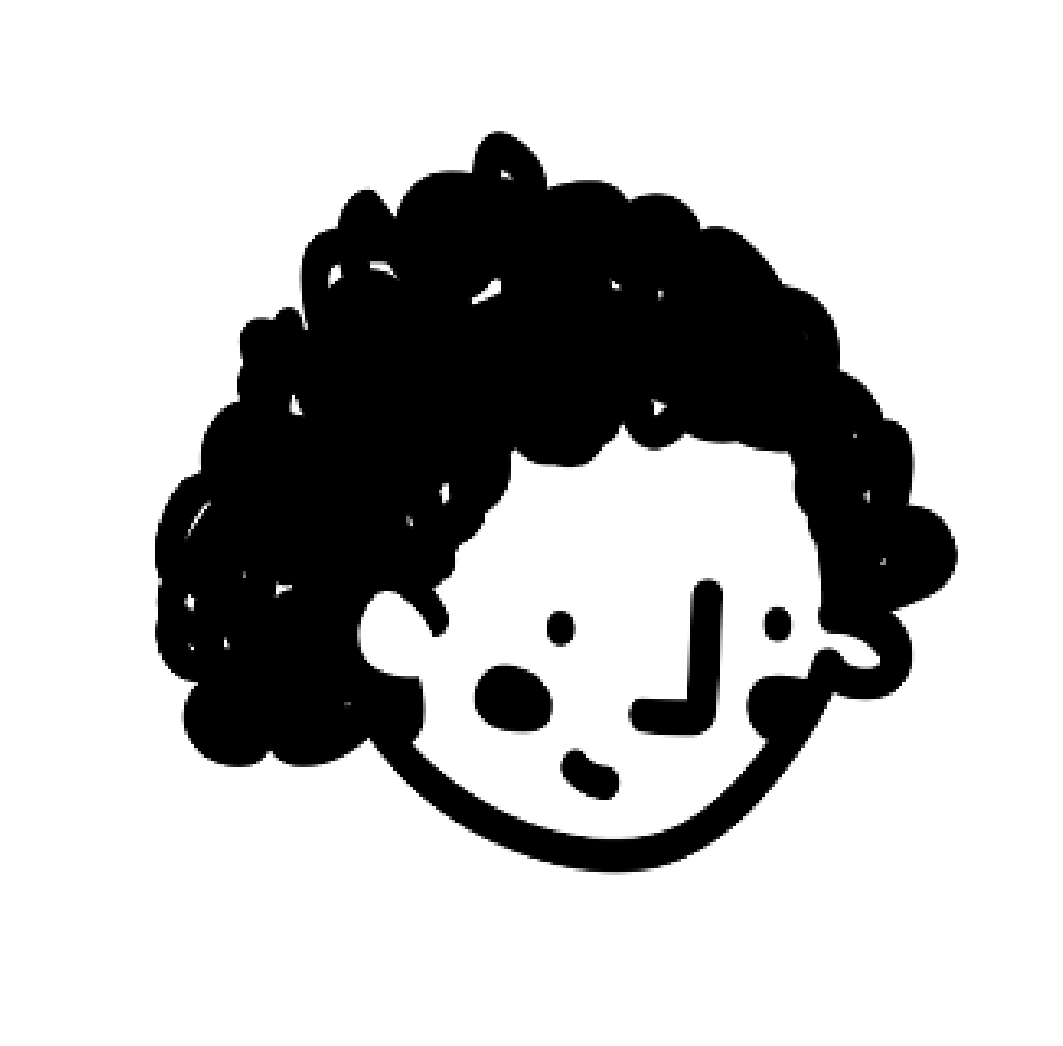

In [2]:
pic_path = "../Dataset/tfrecord/pictogram.tfrecord"
real_path = "../Dataset/tfrecord/real_image.tfrecord"

pic_images = []
pic_sexes = []
real_images = []
real_sexes = []

real_record_iterator = tf.python_io.tf_record_iterator(path=real_path)
pic_record_iterator = tf.python_io.tf_record_iterator(path=pic_path)


for str_real_record, str_pic_record in zip(real_record_iterator, pic_record_iterator):
    example_real = tf.train.Example()
    example_real.ParseFromString(str_real_record)
    
    height = int(example_real.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example_real.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example_real.features.feature['gray_img_bytes']
                                  .bytes_list
                                  .value[0])
    
    sex = float(example_real.features.feature['sex']
                                .float_list
                                .value[0])
    
    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    # 마지막 axis에 7개의 0이 추가 된다. 
    reconstructed_img = np.amax(reconstructed_img, axis=-1)

    real_images.append(reconstructed_img)
    real_sexes.append(sex)
    
    example_pic = tf.train.Example()
    example_pic.ParseFromString(str_pic_record)
    
    height = int(example_pic.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example_pic.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example_pic.features.feature['gray_img_bytes']
                                  .bytes_list
                                  .value[0])
    
    sex = float(example_pic.features.feature['sex']
                                .float_list
                                .value[0])
    
    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    # 마지막 axis에 7개의 0이 추가 된다. 
    reconstructed_img = np.amax(reconstructed_img, axis=-1)

    pic_images.append(reconstructed_img)
    pic_sexes.append(sex)
    

       
plt.figure(figsize=(9,9))
plt.axis("off")
plt.imshow(reconstructed_img, cmap="gray")
plt.show()

In [3]:
pic_images = np.array(pic_images).reshape(-1, height, width, 1)
real_images = np.array(real_images).reshape(-1, height, width, 1)

In [4]:
pic_images =  pic_images.astype(np.float32)
real_images = real_images.astype(np.float32)
pic_images.shape, real_images.shape

((34, 300, 300, 1), (34, 300, 300, 1))

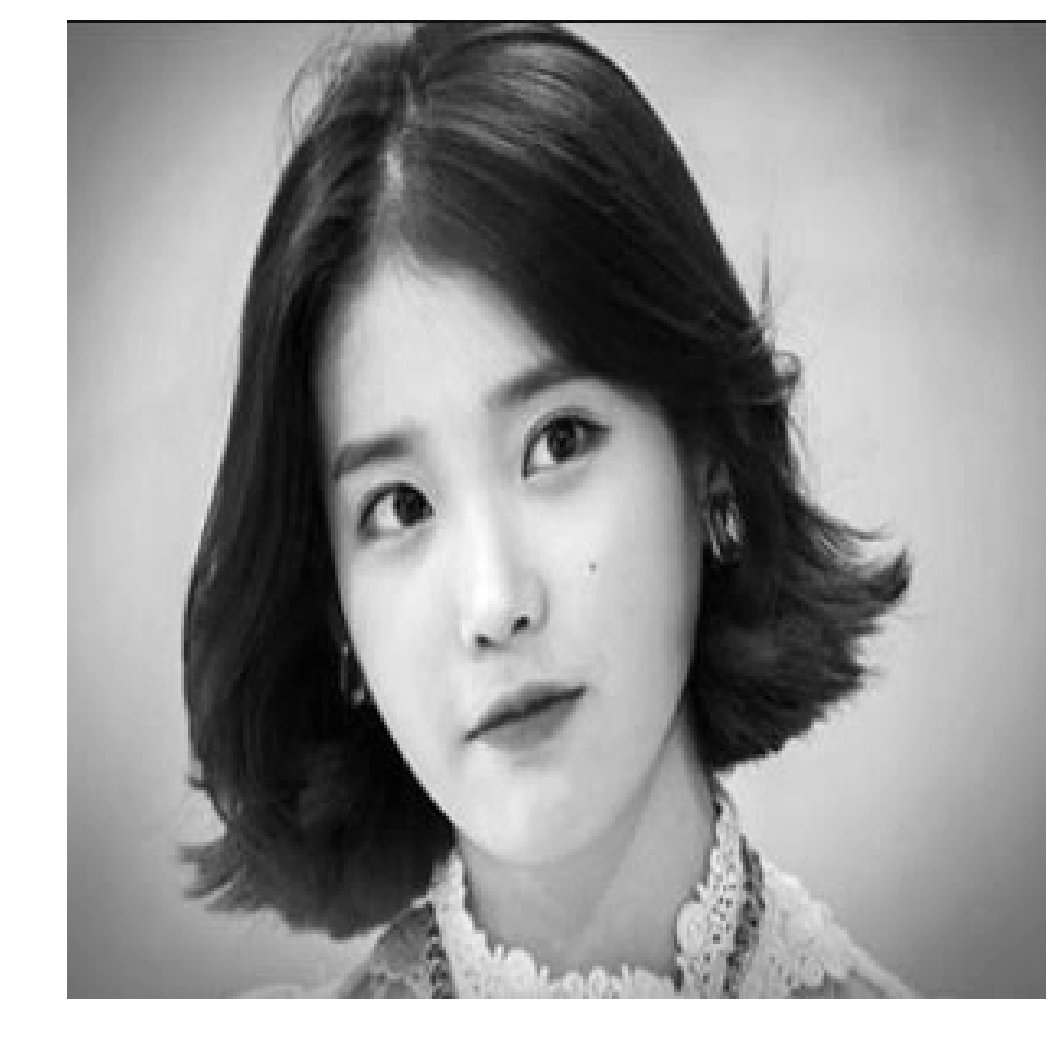

In [5]:
plt.figure(figsize=(9,9))
plt.axis("off")
plt.imshow(real_images[11].reshape(300, 300), cmap="gray")
plt.show()

In [6]:
np.unique(pic_images[1])

array([ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
       120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 16

In [7]:
import math
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops

#### Defining functions 

In [8]:
# powerful normalization method for style trasfering problem, which normaaly has few dataset 
def instance_norm(x, name="instance_norm"):
    """
    instance normalization 
    paper's link = https://arxiv.org/pdf/1607.08022.pdf
    'it increases style transfering models' perfomance' 
    """
    with tf.variable_scope(name):
        depth = x.get_shape()[3]
        # two learnable parameters : scale, offset 
        scale = tf.get_variable("scale", [depth], initializer=tf.random_normal_initializer(1.0, 0.02, dtype=tf.float32))
        offset = tf.get_variable("offset", [depth], initializer=tf.constant_initializer(0.0))
        mean, variance = tf.nn.moments(x, axes=[1,2], keep_dims=True)
        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (x-mean)*inv
        return scale*normalized + offset
# conv2d 
def conv2d(input_, output_dim=8, kernel_size=5, stride=1, stddev=0.02, padding='SAME', name="conv2d"):
    """ generating conv2d layer
    
    args :
    input_ : input 
    output_dim : output_dim
    kernel_size : 4
    stride : 2 
    stddev : tf.truncated_normal_initializer(stddev=stddev)
    padding : SAME
    name : conv2d
    
    return :
    slim.conv2d(input_, output_dim, kernel_size, stride, padding=padding, activation_fn=None,
                            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

    """
    with tf.variable_scope(name):
        return slim.conv2d(input_, output_dim, kernel_size=kernel_size, stride=stride, 
                           padding=padding, activation_fn=None,
                            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

#leaky relu    
def lrelu(x, leaky=0.2, name="leaky_relu"):
    
    return tf.maximum(x, leaky * x)


#### Creating Generator & Discriminator 

In [9]:
def discriminator(image, output_dim=8, reuse=False, name="discriminator"):
    with tf.variable_scope(name):
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else :
            assert tf.get_variable_scope().reuse is False

        # h0 is (150 x 150 x self.df_dim)
        h0 = lrelu(conv2d(image, output_dim, stride=2, name='dis_h0_conv'))
        # h1 is (75 x 75 x self.df_dim*2)
        h1 = lrelu(instance_norm(conv2d(h0, output_dim*2, stride=2, name='d_h1_conv'), 'd_in1'))
        # h2 is (36 x 36 x self.df_dim*4)
        h2 = lrelu(instance_norm(conv2d(h1, output_dim*4, stride=2, name='d_h2_conv'), 'd_in2'))
        # h3 is (36 x 36 x self.df_dim*8)
        h3 = lrelu(instance_norm(conv2d(h2, output_dim*8, name='d_h3_conv'), 'd_in3'))
        # h4 is (36 x 36 x 1)
        h4 = conv2d(h3, 1, name='d_h3_pred')

        return h4

    
def generator_dense(image, reuse=False, name="generator"):
    with tf.variable_scope(name):
        # image = 300x300x1
        
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False
            
        def dense_block(x, growth_rate=8, num_layers_in_block=6, name="dense"):
            
            for i in range(num_layers_in_block):    
                y1 = instance_norm(conv2d(x, growth_rate*2, 
                                          kernel_size=1,
                                          padding='SAME', 
                                          name=name+'_bot{}'.format(i)), name+'_in1{}'.format(i))
                y2 = instance_norm(conv2d(y1, growth_rate, 
                                          kernel_size=3, 
                                          padding='SAME', 
                                          name=name+'_tle{}'.format(i)), name+'_in2{}'.format(i))

                x = tf.concat([y2, x], -1)
                
            return x
                
                
        dense_layer_1 = dense_block(image, name="dense_1")
        
        # Maintaing Feature map size , Reduce # of channels  
        transition_layer = instance_norm(conv2d(dense_layer_1, 1, 
                                          kernel_size=3, 
                                          padding='SAME', 
                                          name=name+'_transition1'), name+'_in1')
        
        dense_layer_2 = dense_block(transition_layer, name="dense_2")
        
        
        output_layer = instance_norm(conv2d(dense_layer_2, 1, 
                                          kernel_size=3, stride=1, 
                                          padding='SAME', 
                                          name=name+'_out'), name+'_in_out')
        
        
        return output_layer
    
    
# Loss functions     

def abs_criterion(in_, target):
    return tf.reduce_mean(tf.abs(in_ - target))


def mse_criterion(in_, target):
    return tf.reduce_mean((in_ - target)**2)


def sce_criterion(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))


#### Modeling 

In [10]:
# L1_lambda = 10 # from paper -> it wasnt that good 

L1_lambda = 0.5
height = 300 
width = 300 

# True image 
# face_pic_data = tf.placeholder(tf.float32, 
#                               [None, height, width, 2])

# face = face_pic_data[:,:,:, 0]
# pic = face_pic_data[:,:,:, 1]

face = tf.placeholder(tf.float32, [None, height, width, 1])
pic = tf.placeholder(tf.float32, [None, height, width, 1])

# Fake image 
# Face -> pic -> Face'
fake_pic = generator_dense(face, name="generator_Face2Pic")
fake_face_ = generator_dense(fake_pic, name="generator_Pic2Face")
# Pic -> Face -> Pic'
fake_face = generator_dense(pic, reuse=True, name="generator_Pic2Face")
fake_pic_ = generator_dense(fake_face, reuse=True, name="generator_Face2Pic")
#############################################
dis_pic_fake = discriminator(fake_pic, reuse=False, name='discriminator_Pic')
dis_face_fake = discriminator(fake_face, reuse=False, name='discriminator_Face')

gen_loss_Face2Pic = sce_criterion(dis_pic_fake, tf.ones_like(dis_pic_fake)) + L1_lambda * abs_criterion(face, fake_face_) + L1_lambda * abs_criterion(pic, fake_pic_) 
gen_loss_Pic2Face = sce_criterion(dis_face_fake, tf.ones_like(dis_face_fake)) + L1_lambda * abs_criterion(face, fake_face_) + L1_lambda * abs_criterion(pic, fake_pic_) 
gen_loss = sce_criterion(dis_pic_fake, tf.ones_like(dis_pic_fake)) + sce_criterion(dis_face_fake, tf.ones_like(dis_face_fake))+ L1_lambda * abs_criterion(face, fake_face_) + L1_lambda * abs_criterion(pic, fake_pic_)
######################################################
fake_face_sample = tf.placeholder(tf.float32, 
                                 [None, height, width, 1], name='fake_face') 
fake_pic_sample = tf.placeholder(tf.float32, 
                                 [None, height, width, 1], name='fake_pic') 

dis_pic_real = discriminator(pic, reuse=True, name='discriminator_Pic')
dis_face_real = discriminator(face, reuse=True, name='discriminator_Face')

dis_fake_face_sample = discriminator(fake_face_sample, reuse=True, name="discriminator_Face") 
dis_fake_pic_sample = discriminator(fake_pic_sample, reuse=True, name="discriminator_Pic")

dis_pic_loss_real = sce_criterion(dis_pic_real, tf.ones_like(dis_pic_real))
dis_pic_loss_fake = sce_criterion(dis_fake_pic_sample, tf.zeros_like(dis_fake_pic_sample))
dis_pic_loss = (dis_pic_loss_fake + dis_pic_loss_real) / 2

dis_face_loss_real = sce_criterion(dis_face_real, tf.ones_like(dis_face_real))
dis_face_loss_fake = sce_criterion(dis_fake_face_sample, tf.zeros_like(dis_fake_face_sample))
dis_face_loss = (dis_face_loss_fake + dis_face_loss_real) / 2

##### 
dis_loss = dis_pic_loss + dis_face_loss

## for summary 

####### Generator
gen_loss_Face2Pic_summ = tf.summary.scalar("gen_loss_Face2Pic", gen_loss_Face2Pic)
gen_loss_Pic2Face_summ = tf.summary.scalar("gen_loss_Pic2Face", gen_loss_Pic2Face)
gen_loss_summ = tf.summary.scalar("gen_loss", gen_loss)

gen_summ = tf.summary.merge([gen_loss_Face2Pic_summ, gen_loss_Pic2Face_summ, gen_loss_summ])

####### Discriminator
dis_pic_loss_real_summ = tf.summary.scalar("dis_pic_loss_real", dis_pic_loss_real)
dis_pic_loss_fake_summ = tf.summary.scalar("dis_pic_loss_fake", dis_pic_loss_fake)
dis_pic_loss_summ = tf.summary.scalar("dis_pic_loss", dis_pic_loss)
dis_face_loss_real_summ = tf.summary.scalar("dis_face_loss_real", dis_face_loss_real)
dis_face_loss_fake_summ = tf.summary.scalar("dis_face_loss_fake", dis_face_loss_fake)
dis_face_loss_summ = tf.summary.scalar("dis_face_loss", dis_face_loss)
dis_loss_summ = tf.summary.scalar("dis_loss", dis_loss)

dis_summ =tf.summary.merge([dis_pic_loss_real_summ, dis_pic_loss_fake_summ,dis_pic_loss_summ, 
                          dis_face_loss_real_summ, dis_face_loss_fake_summ, dis_face_loss_summ,
                         dis_loss_summ])

###### Testing 

test_face = tf.placeholder(tf.float32, 
                          [None, height, width, 1], name='test_Face')
test_pic = tf.placeholder(tf.float32, 
                          [None, height, width, 1], name='test_Pic')

test_pic_result = generator_dense(test_face, reuse=True, name="generator_Face2Pic")
test_face_result = generator_dense(test_pic, reuse=True, name="generator_Pic2Face")

lr = 0.001
total_variables = tf.trainable_variables()
dis_var = [var for var in total_variables if 'discriminator' in var.name]
gen_var = [var for var in total_variables if 'generator' in var.name]

epochs = 500

## optimizers 
dis_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(dis_loss, var_list=dis_var)
gen_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(gen_loss, var_list=gen_var)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

#### Train and Save Model

INFO:tensorflow:Restoring parameters from ./model/Face_to_Pic.model
Epoch : 0/500, time : 59.94013547897339, 


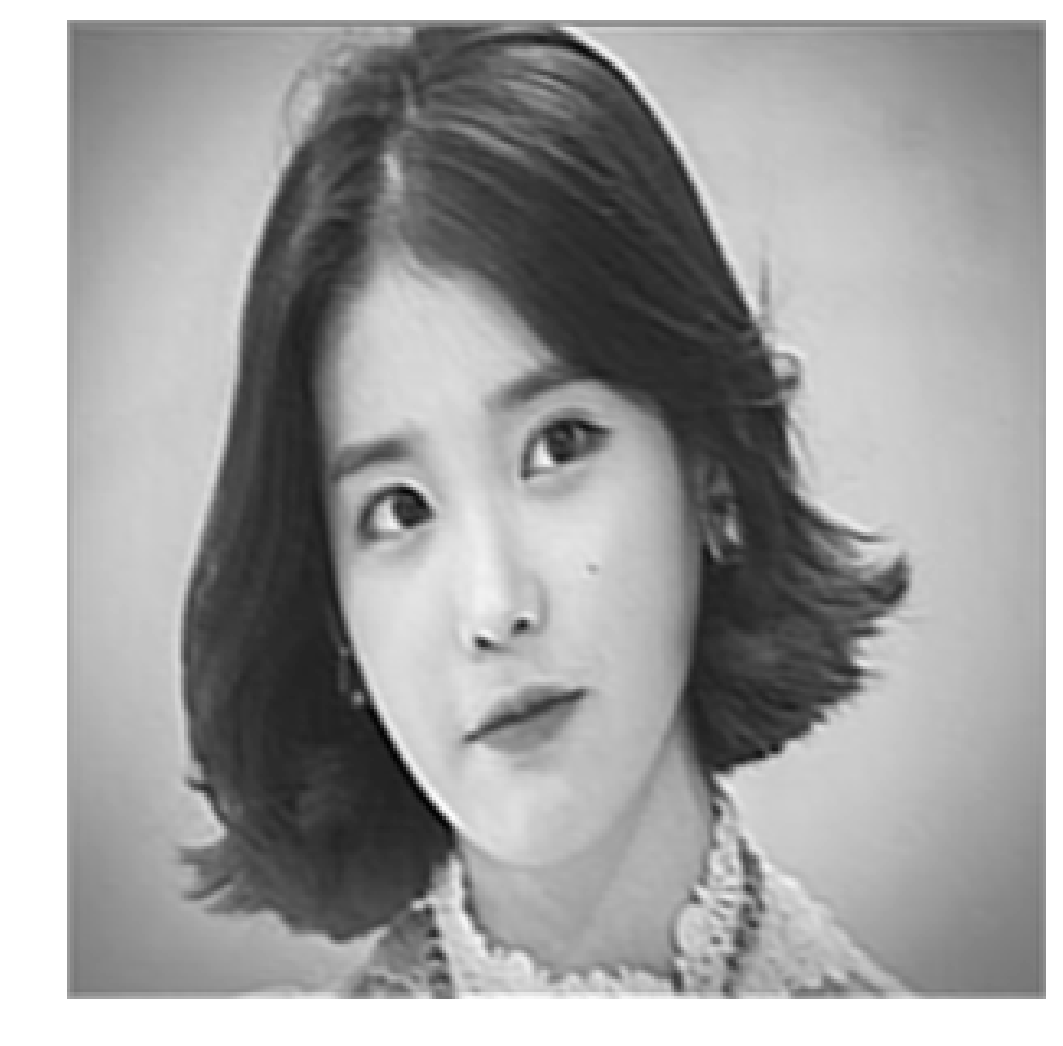

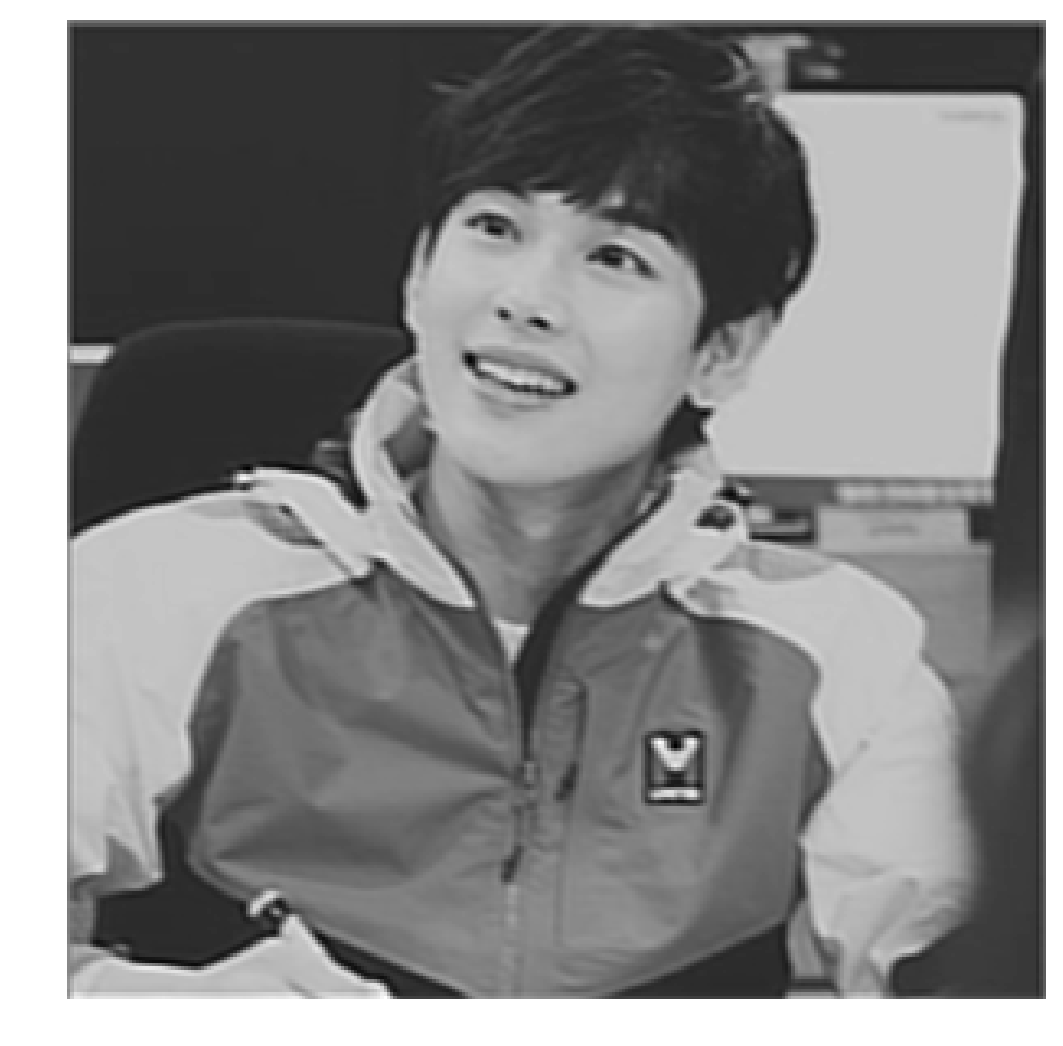

Epoch : 1/500, time : 35.30899930000305, 
Epoch : 2/500, time : 33.631768465042114, 
Epoch : 3/500, time : 33.60176920890808, 
Epoch : 4/500, time : 33.61408615112305, 
Epoch : 5/500, time : 33.612133741378784, 
Epoch : 6/500, time : 33.61338019371033, 
Epoch : 7/500, time : 33.64000082015991, 
Epoch : 8/500, time : 33.645209074020386, 
Epoch : 9/500, time : 33.600282192230225, 
Epoch : 10/500, time : 33.61707615852356, 
Epoch : 11/500, time : 33.638832330703735, 
Epoch : 12/500, time : 33.641523361206055, 
Epoch : 13/500, time : 33.61972641944885, 
Epoch : 14/500, time : 33.61308026313782, 
Epoch : 15/500, time : 33.6321702003479, 
Epoch : 16/500, time : 33.63295888900757, 
Epoch : 17/500, time : 33.62510561943054, 
Epoch : 18/500, time : 33.620176553726196, 
Epoch : 19/500, time : 33.655030965805054, 
Epoch : 20/500, time : 33.638526916503906, 
Epoch : 21/500, time : 33.63464856147766, 
Epoch : 22/500, time : 33.62347102165222, 
Epoch : 23/500, time : 33.647926807403564, 
Epoch : 24/

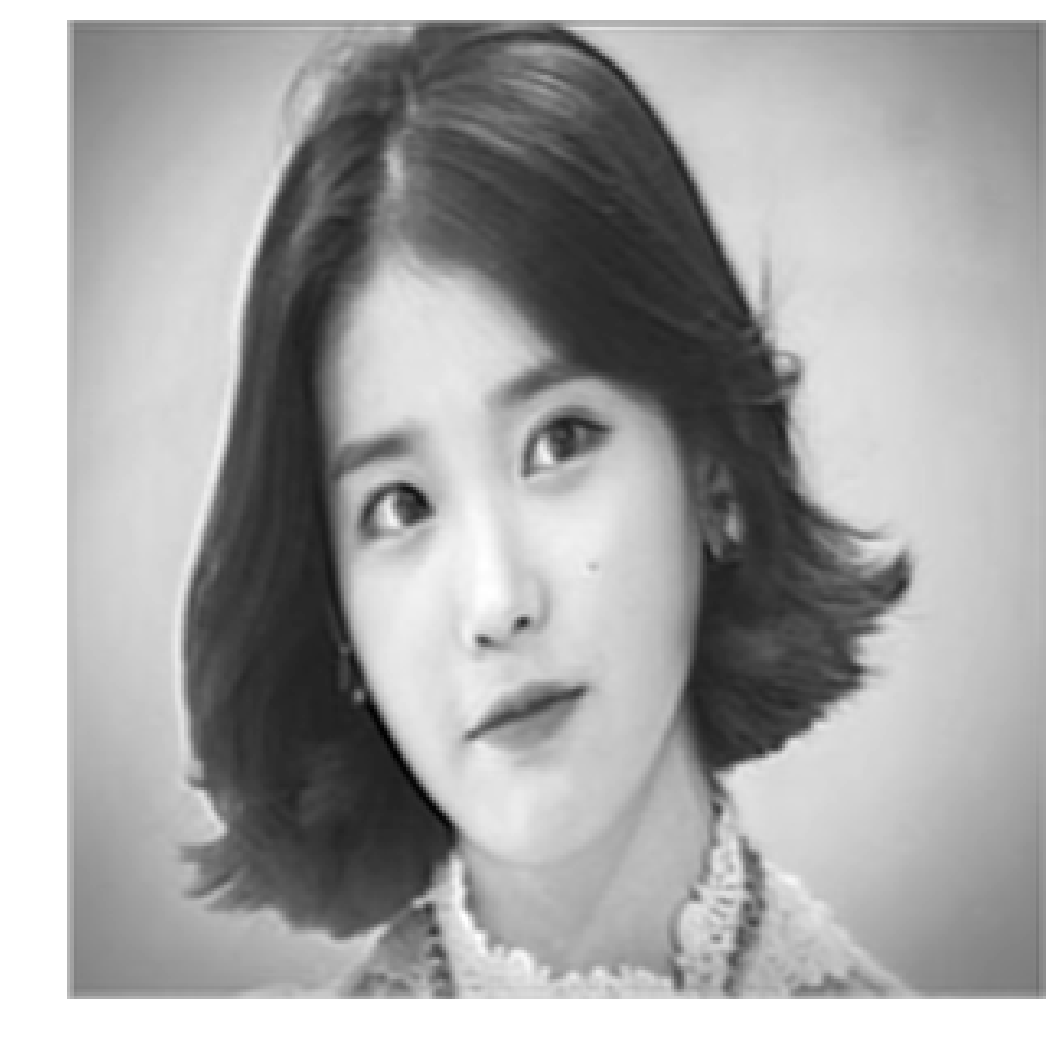

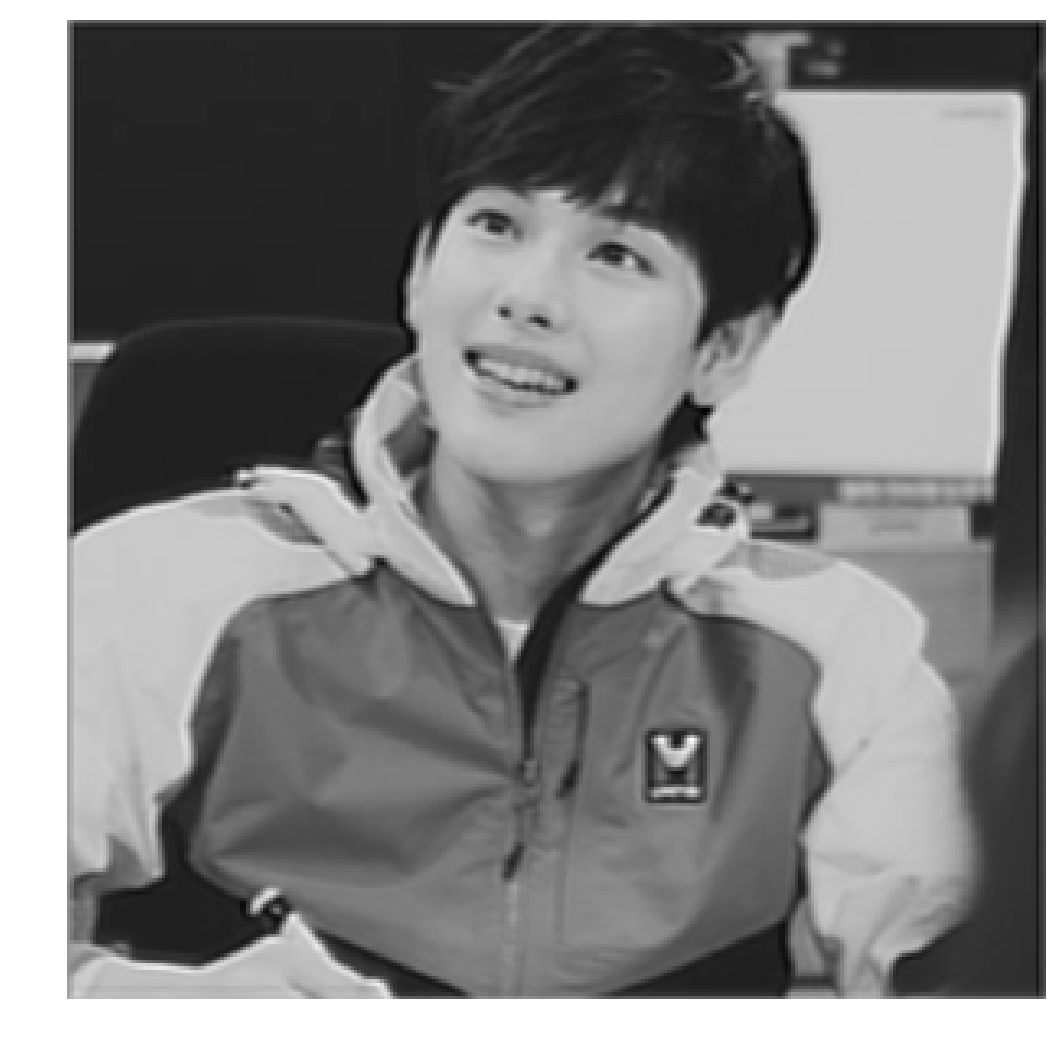

Epoch : 101/500, time : 34.82021713256836, 
Epoch : 102/500, time : 33.616599559783936, 
Epoch : 103/500, time : 33.619030714035034, 
Epoch : 104/500, time : 33.62537479400635, 
Epoch : 105/500, time : 33.61922478675842, 
Epoch : 106/500, time : 33.631147384643555, 
Epoch : 107/500, time : 33.638782024383545, 
Epoch : 108/500, time : 33.631962299346924, 
Epoch : 109/500, time : 33.66004657745361, 
Epoch : 110/500, time : 33.627055406570435, 
Epoch : 111/500, time : 33.6166570186615, 
Epoch : 112/500, time : 33.62504029273987, 
Epoch : 113/500, time : 33.62044358253479, 
Epoch : 114/500, time : 33.61884951591492, 
Epoch : 115/500, time : 33.637643814086914, 
Epoch : 116/500, time : 33.64329981803894, 
Epoch : 117/500, time : 33.63979721069336, 
Epoch : 118/500, time : 33.61213445663452, 
Epoch : 119/500, time : 33.607586145401, 
Epoch : 120/500, time : 33.637725830078125, 
Epoch : 121/500, time : 33.667145013809204, 
Epoch : 122/500, time : 33.648682832717896, 
Epoch : 123/500, time : 3

In [ ]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_name = "Face_to_Pic.model"
model_dir = "./model"
model_file = os.path.join(model_dir, model_name)
with tf.Session(config=config) as sess:
    saver = tf.train.Saver() # I created variables with names 
    saver.restore(sess, model_file) # when keep training continuously 
#     init_op = tf.global_variables_initializer()
#     sess.run(init_op)
    writer = tf.summary.FileWriter("./logs", sess.graph)
    start_time = time.time()
    counter = 1
    for epoch in range(epochs):
        # 임시방편으로 batch 를 썻다 -> 나중에 iterator로 처리 하자 
        batch_face1, batch_face2, batch_face3, batch_face4, batch_face5, batch_face6, batch_face7, batch_face8 = real_images[:5], real_images[5:10], real_images[10:15], real_images[15:20], real_images[20:25], real_images[25:30], real_images[30:32], real_images[32:]  
        batch_pic1, batch_pic2, batch_pic3, batch_pic4, batch_face5, batch_face6, batch_face7, batch_face8 = pic_images[:5], pic_images[5:10], pic_images[10:15], pic_images[15:20], pic_images[20:25], pic_images[25:30], pic_images[30:32], pic_images[32:]
        

        for batch_face, batch_pic in zip([batch_face1, batch_face2, batch_face3, batch_face4, batch_face5, batch_face6, batch_face7, batch_face8], 
                                         [batch_pic1, batch_pic2, batch_pic3, batch_pic4, batch_face5, batch_face6, batch_face7, batch_face8]):
            ## update Generator and record Fake images 
            fake_Face, fake_Pic, _, summary_str = sess.run(
                                        [fake_face, fake_pic, gen_op, gen_summ], 
                                        feed_dict={face:batch_face, pic:batch_pic})
            writer.add_summary(summary_str, counter)

            ## update Discriminator 

            _, summary_str = sess.run(
                                    [dis_op, dis_summ],
                                feed_dict={
                                    face:batch_face,
                                    pic:batch_pic,
                                    fake_face_sample:fake_Face,
                                    fake_pic_sample:fake_Pic})
            writer.add_summary(summary_str, counter)

            counter += 1 
        print("Epoch : {}/{}, time : {}, ".format(epoch, epochs, time.time() - start_time))
        start_time = time.time()

        if epoch % 100 == 0 :
            test_Face2Pic = sess.run(test_pic_result, feed_dict={test_face:real_images[11:13]})
            for img in test_Face2Pic:
                plt.figure(figsize=(9,9))
                plt.axis("off")
                plt.imshow(img.reshape(300, 300), cmap="gray")
                plt.show()
            
#     saver = tf.train.Saver()

    saver.save(sess, os.path.join(model_dir, model_name))


#### Test 

In [ ]:
with tf.Session() as sess : 
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    test_Face2Pic, test_Pic2Face = sess.run([test_pic_result, test_face_result], feed_dict={test_face:real_images, 
                                                                                           test_pic:pic_images})
    for test_real_img, real_img, test_pic_img, pic_img in zip(test_Face2Pic, real_images, test_Pic2Face, pic_images):
        plt.subplot(1,4,1)
        plt.axis("off")
        plt.imshow(real_img.reshape(300, 300), cmap="gray")
        plt.subplot(1,4,2)
        plt.axis("off")
        plt.imshow(test_real_img.reshape(300, 300), cmap="gray")
        plt.subplot(1,4,3)
        plt.axis("off")
        plt.imshow(pic_img.reshape(300, 300), cmap="gray")
        plt.subplot(1,4,4)
        plt.axis("off")
        plt.imshow(test_pic_img.reshape(300, 300), cmap="gray")
        plt.show()

#### Load model  and Test 

INFO:tensorflow:Restoring parameters from ./model/Face_to_Pic.model


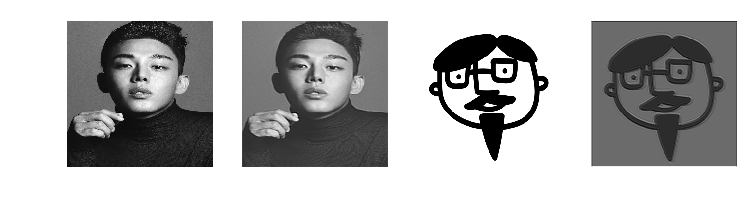

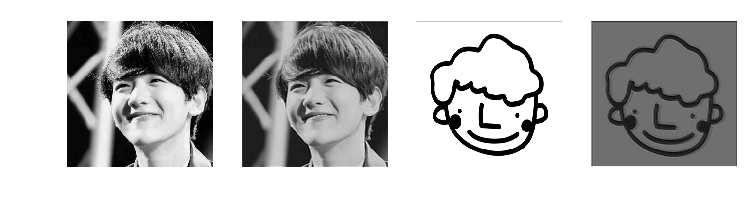

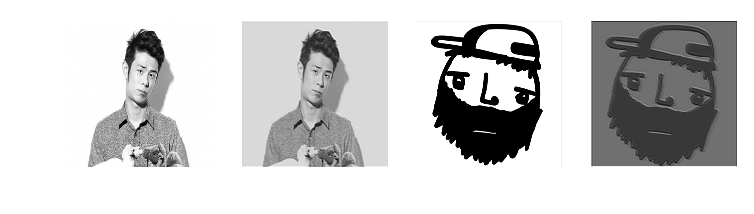

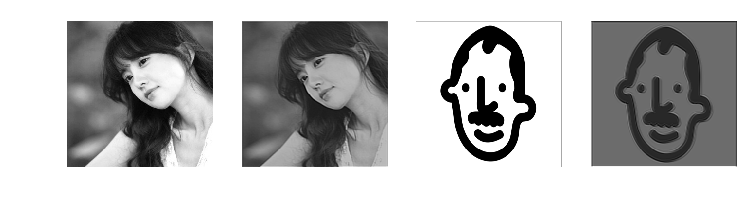

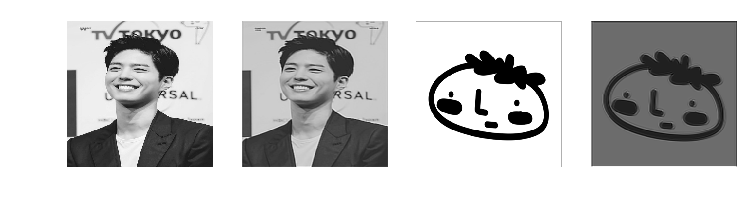

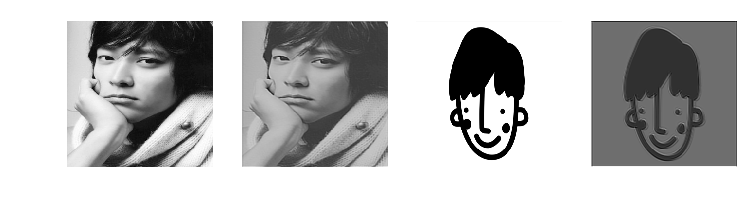

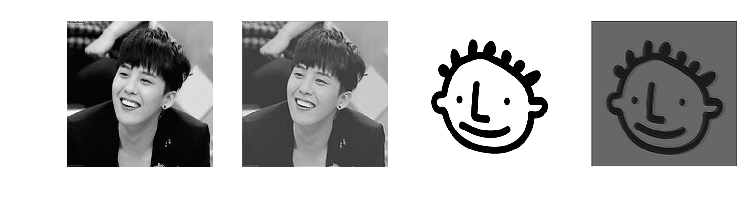

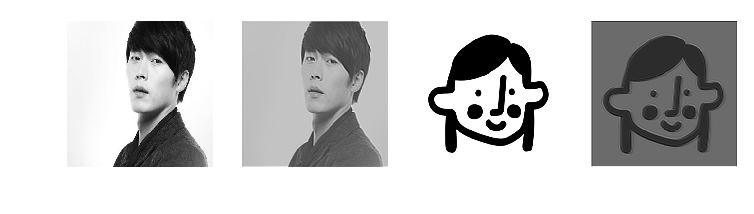

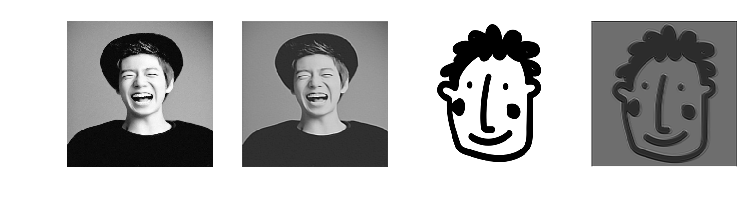

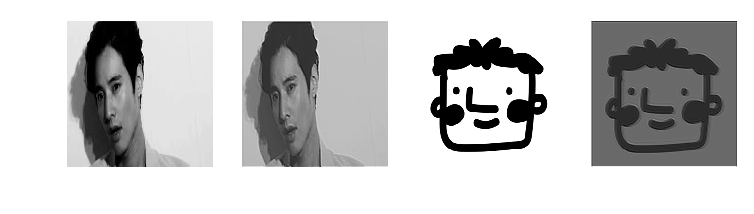

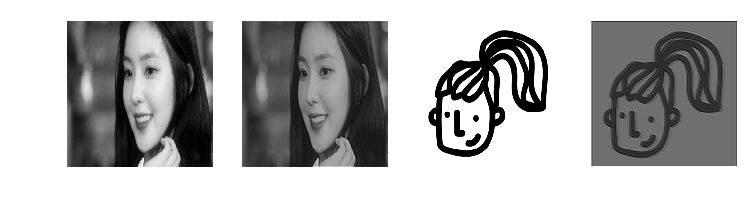

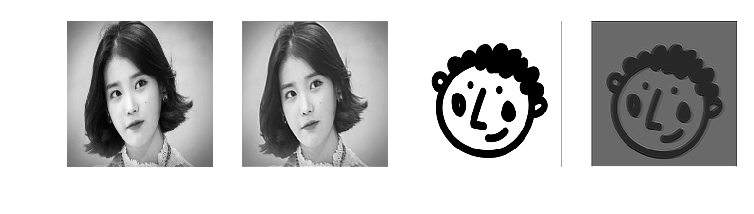

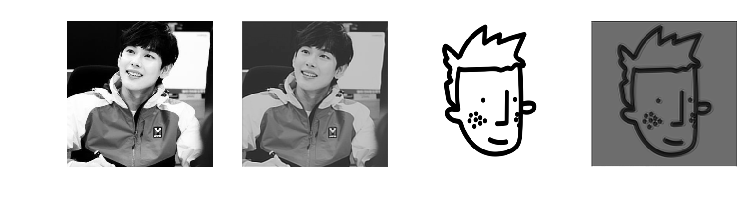

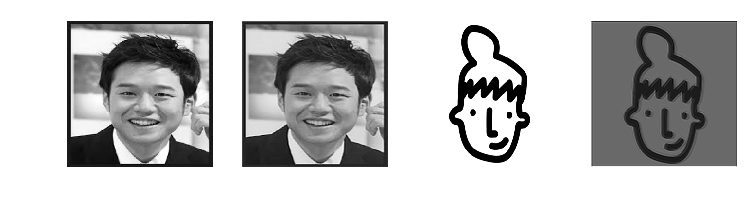

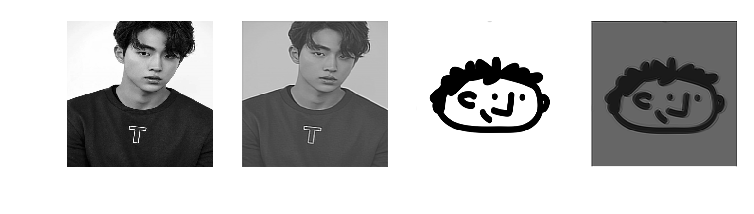

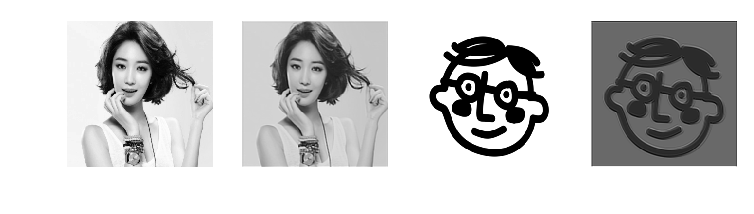

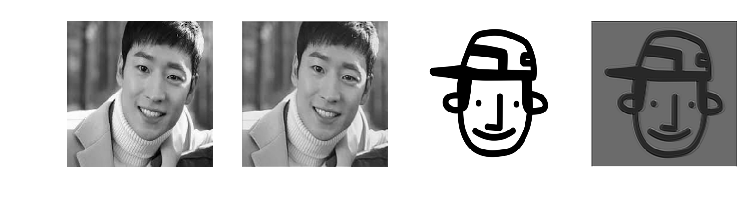

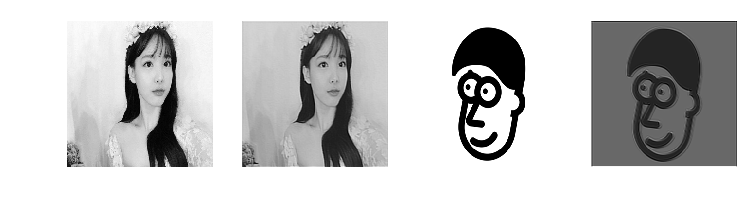

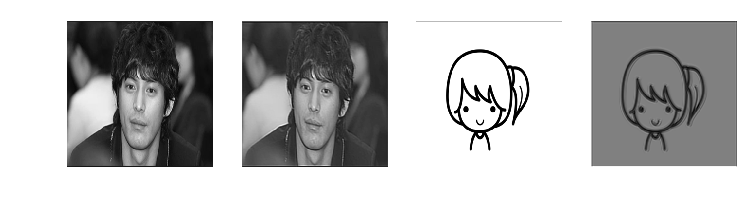

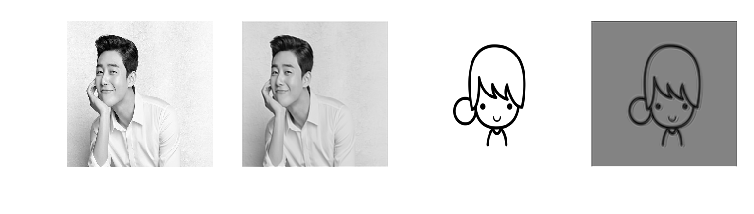

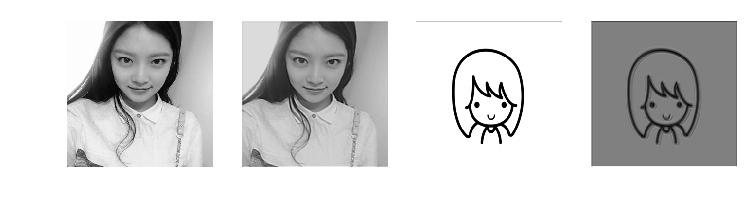

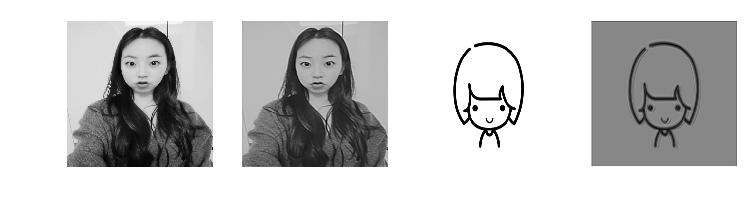

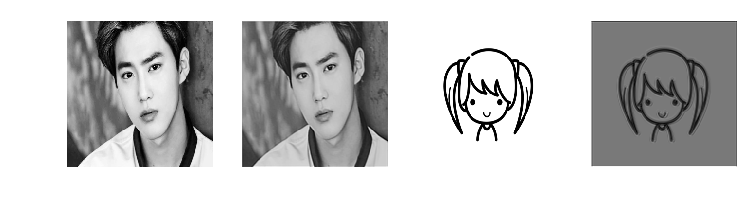

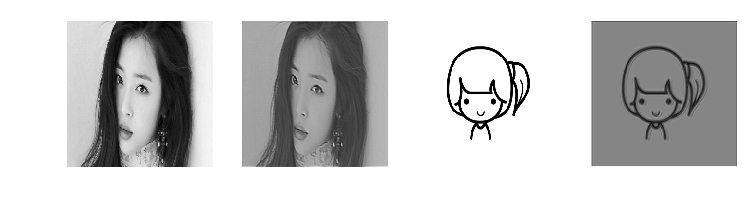

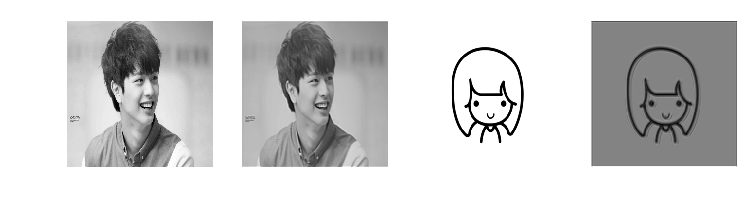

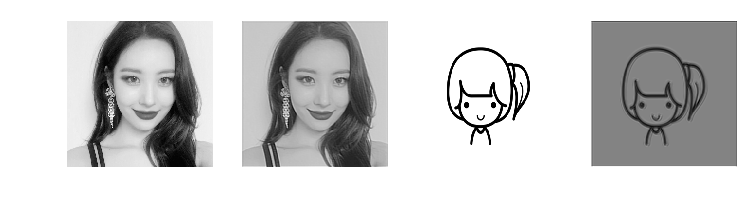

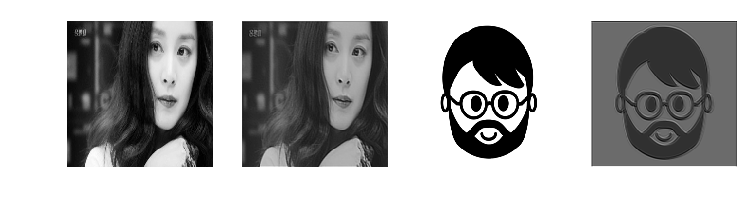

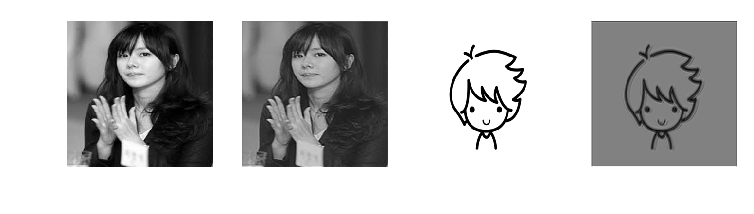

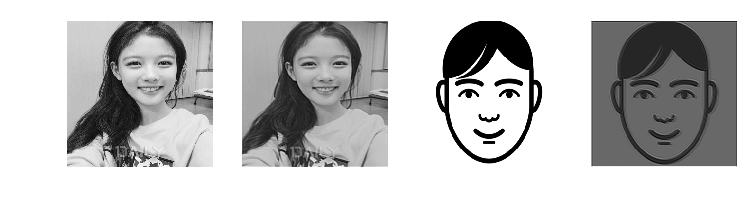

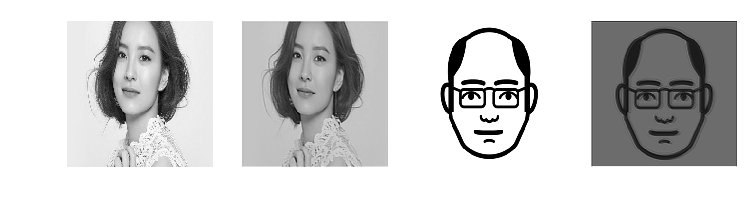

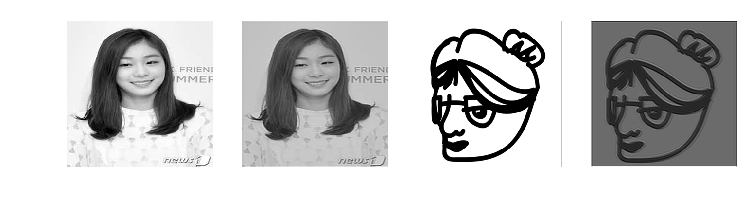

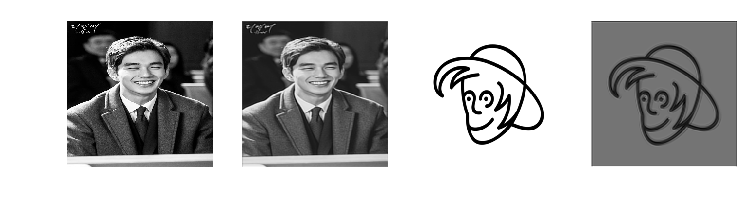

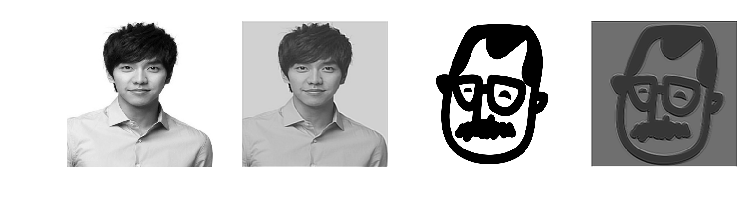

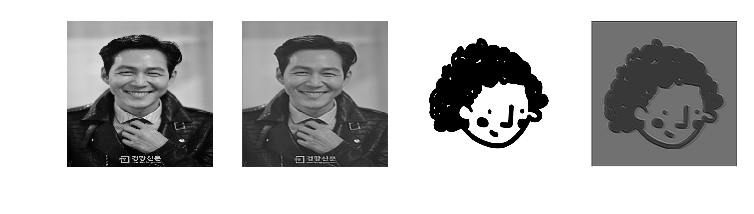

In [22]:
model_dir = "./model/Face_to_Pic.model"

with tf.Session() as sess:
    saver = tf.train.Saver() # I create d
    saver.restore(sess, model_dir)
    real_image_generated = []
    pic_image_generated = []
#     init_op = tf.global_variables_initializer()
#     sess.run(init_op)
    test_Face2Pic, test_Pic2Face = sess.run([test_pic_result, test_face_result], feed_dict={test_face:real_images, 
                                                                                           test_pic:pic_images})
    for test_real_img, real_img, test_pic_img, pic_img in zip(test_Face2Pic, real_images, test_Pic2Face, pic_images):
        real_image_generated.append(test_real_img)
        pic_image_generated.append(test_pic_img)
        plt.subplot(1,4,1)
        plt.axis("off")
        plt.imshow(real_img.reshape(300, 300), cmap="gray")
        plt.subplot(1,4,2)
        plt.axis("off")
        plt.imshow(test_real_img.reshape(300, 300), cmap="gray")
        plt.subplot(1,4,3)
        plt.axis("off")
        plt.imshow(pic_img.reshape(300, 300), cmap="gray")
        plt.subplot(1,4,4)
        plt.axis("off")
        plt.imshow(test_pic_img.reshape(300, 300), cmap="gray")
        plt.show()

#### Idea1. making values be contrasted 

In [23]:
real_image_generated = np.array(real_image_generated)
pic_image_generated = np.array(pic_image_generated)

In [27]:
np.unique(real_image_generated)

array([-0.94816375, -0.9359535 , -0.93289816, ...,  1.7329385 ,
        1.7907864 ,  1.8094338 ], dtype=float32)

In [32]:
for i in range(real_image_generated.shape[0]):
    real_mean = np.mean(real_image_generated[i])
    real_image_generated[i] = np.where(real_image_generated[i] < real_mean, 0, real_image_generated[i])


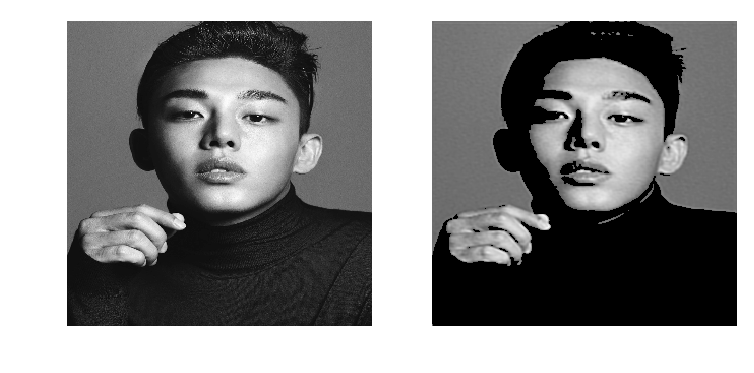

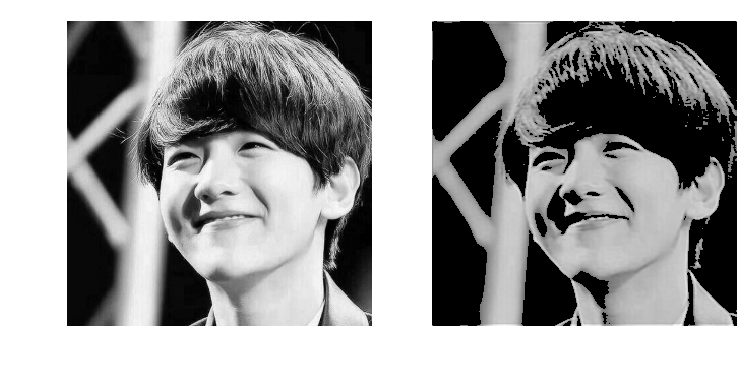

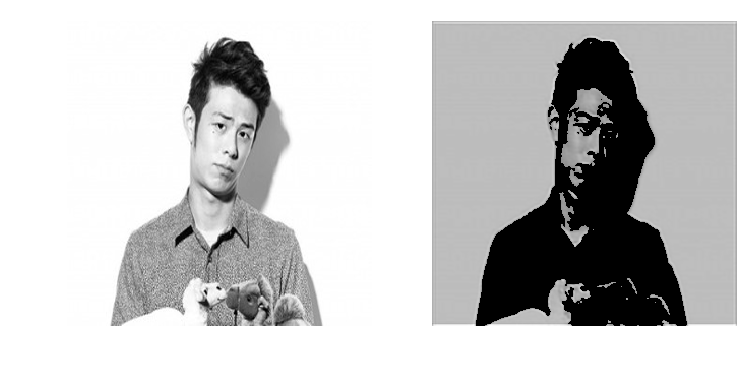

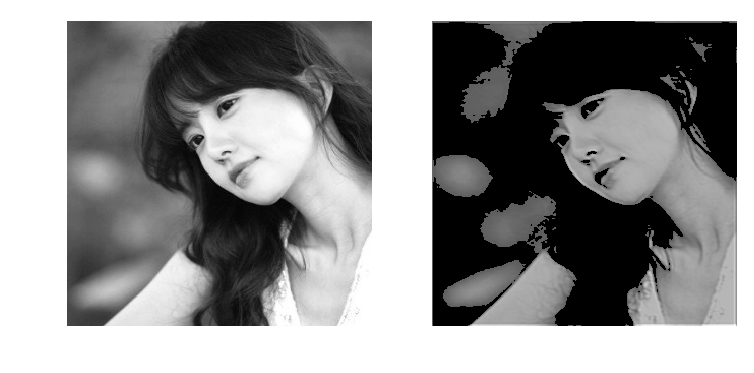

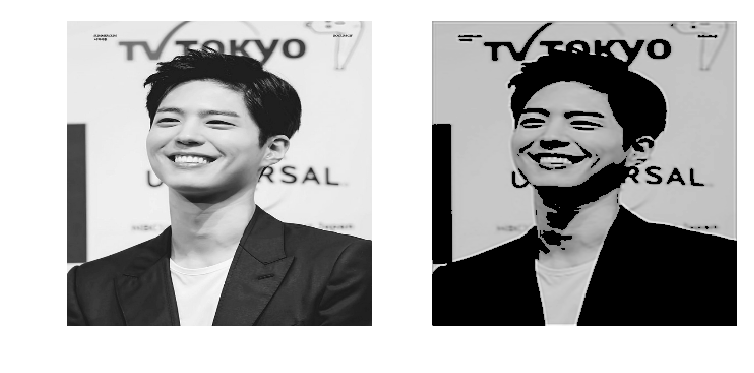

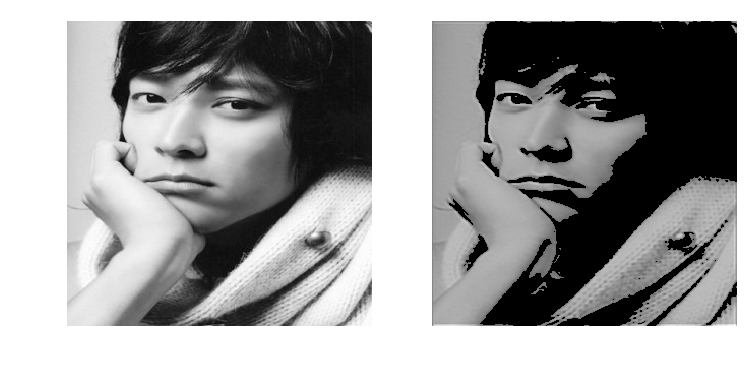

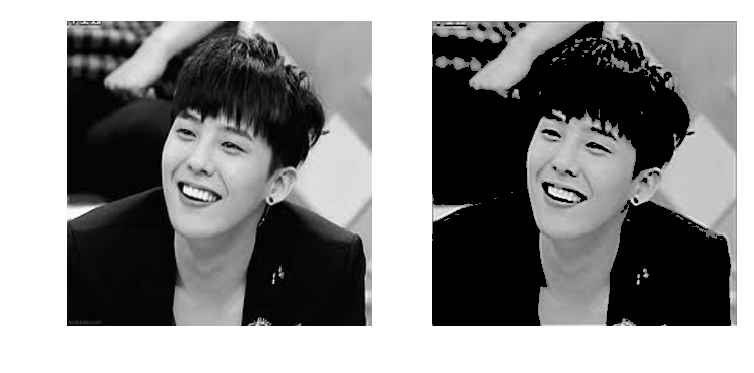

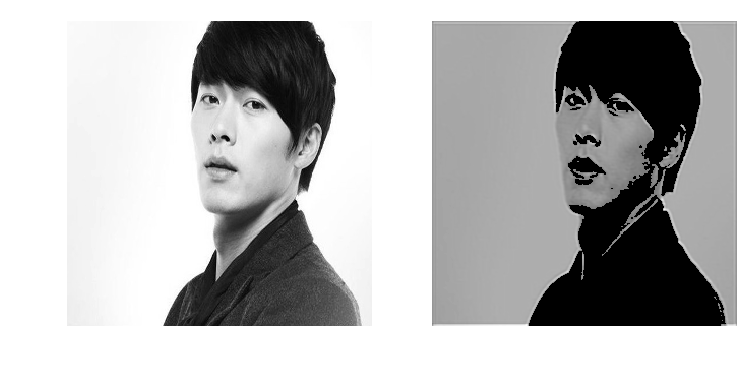

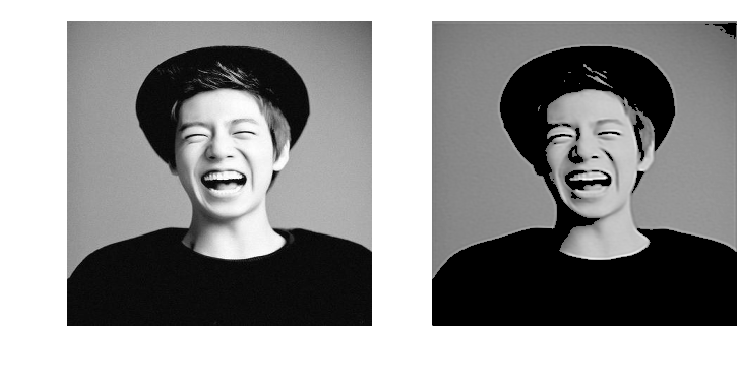

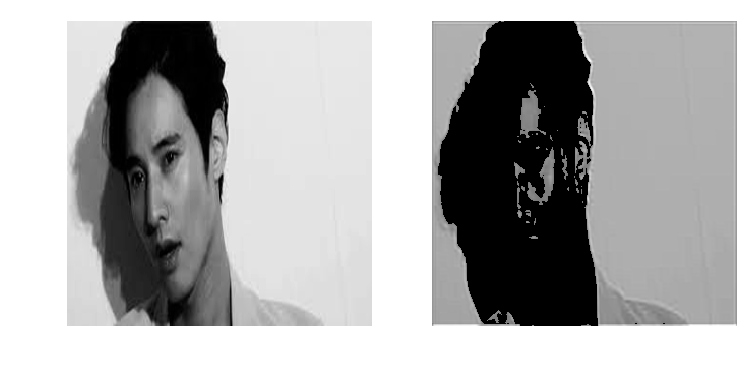

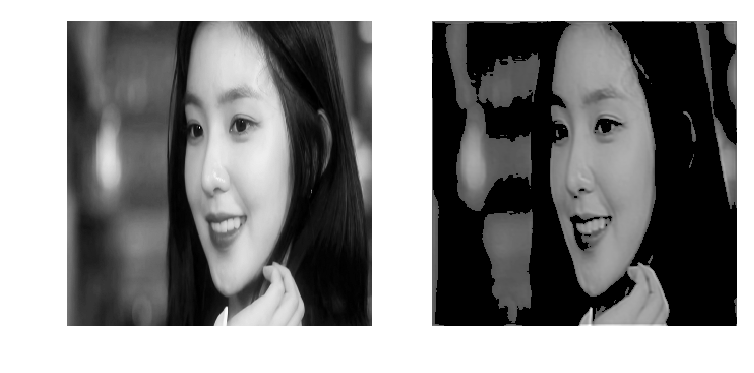

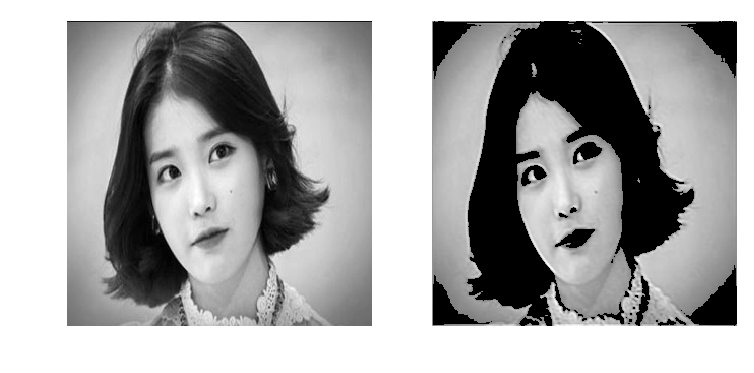

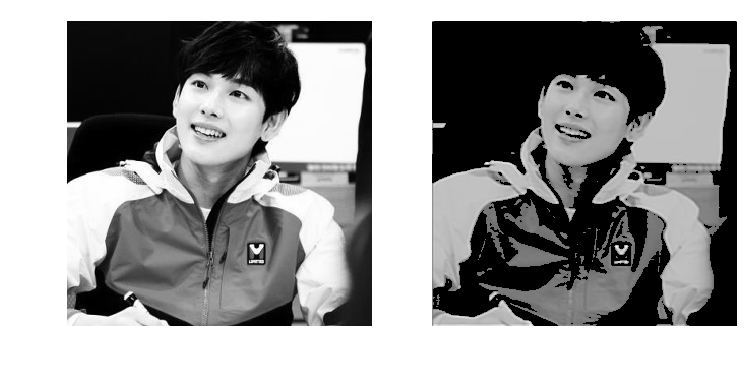

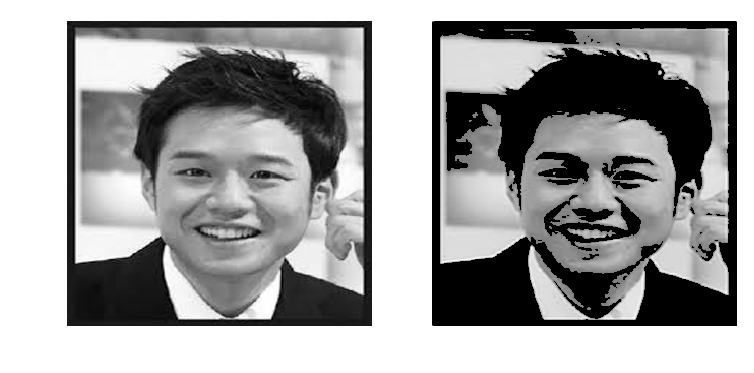

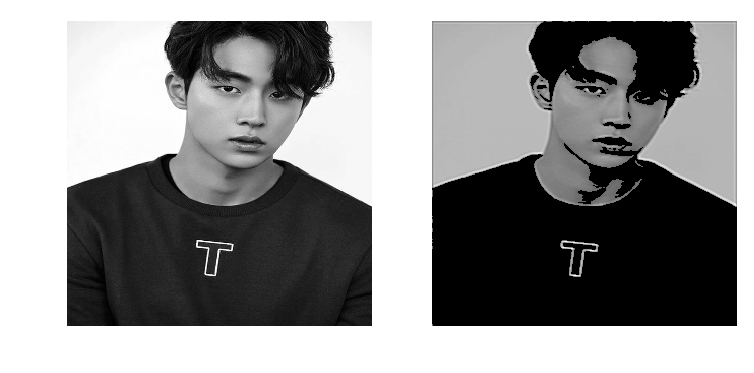

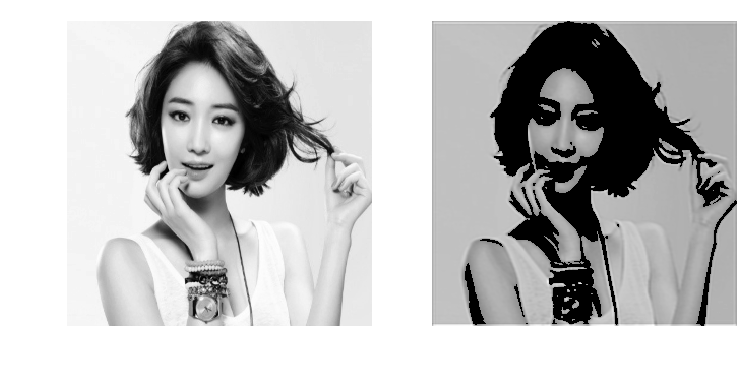

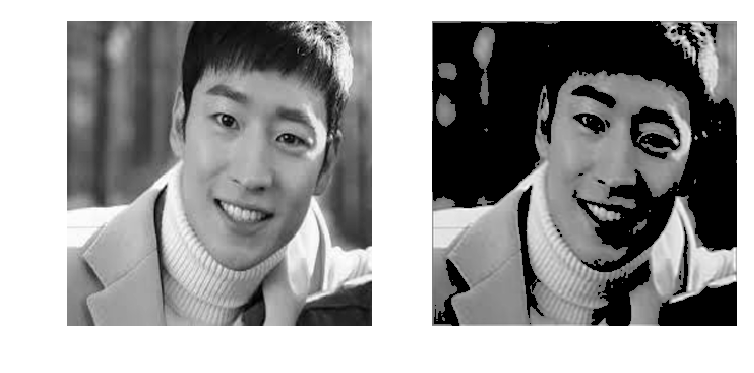

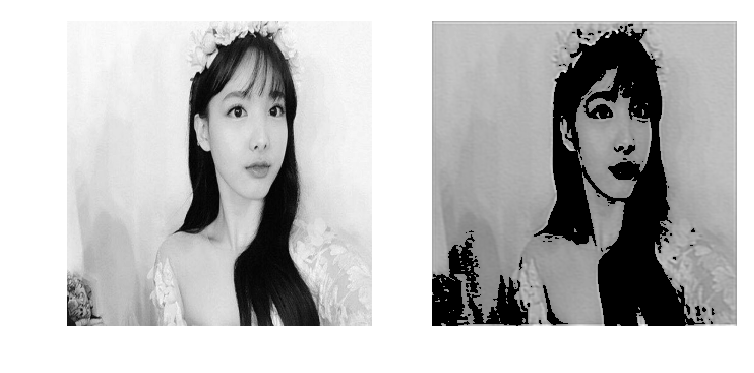

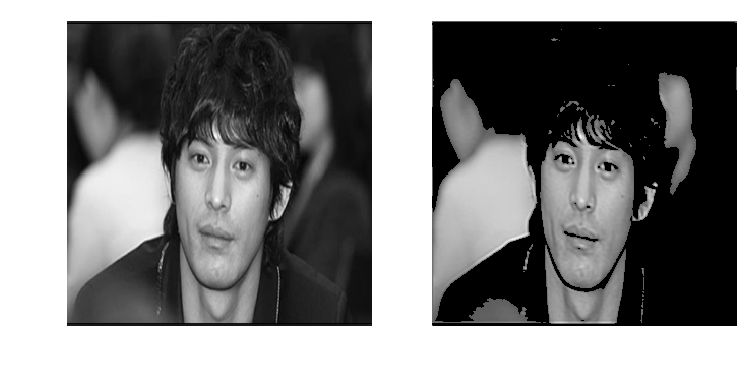

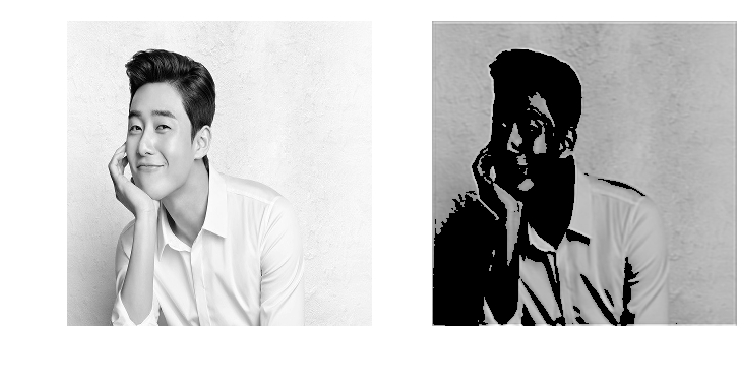

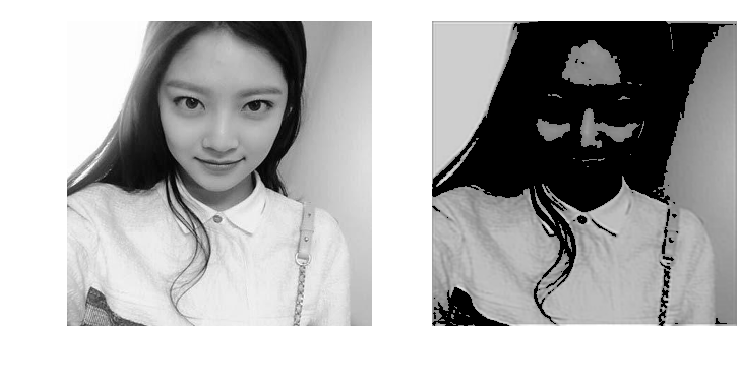

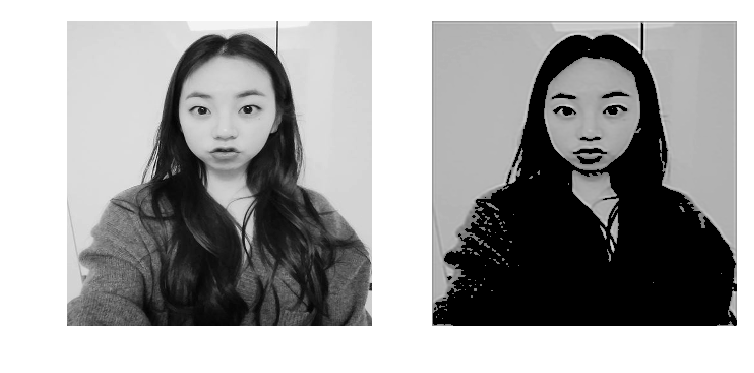

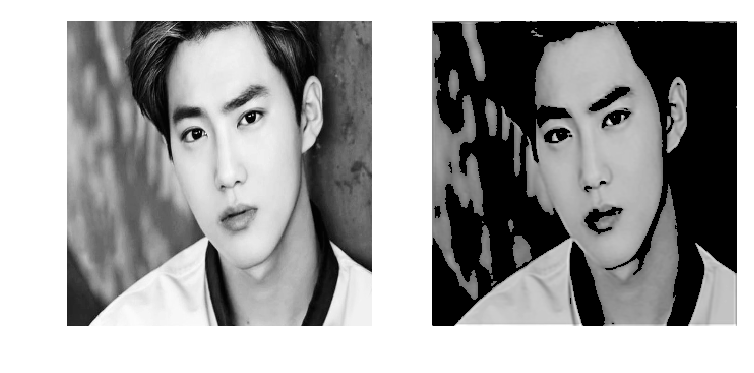

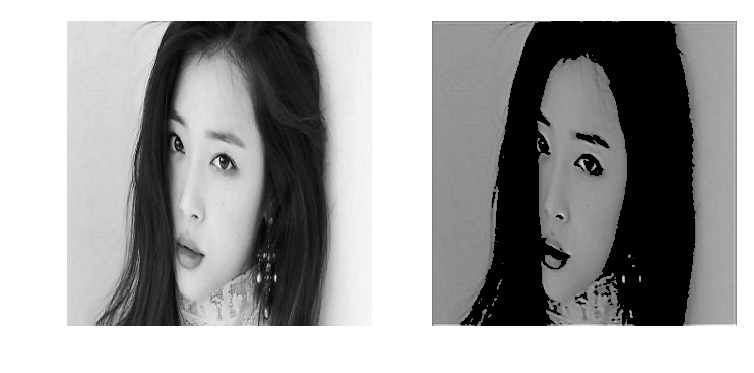

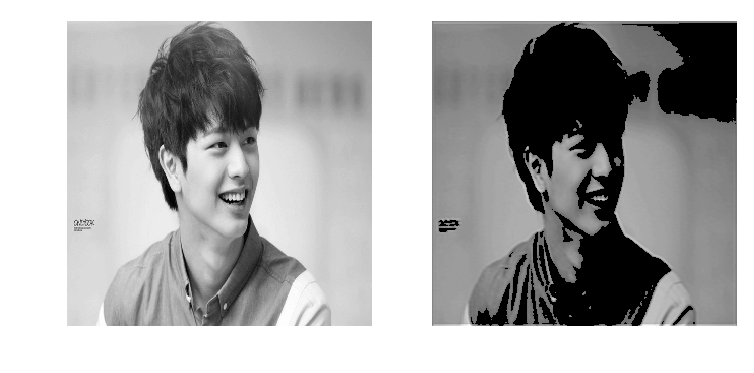

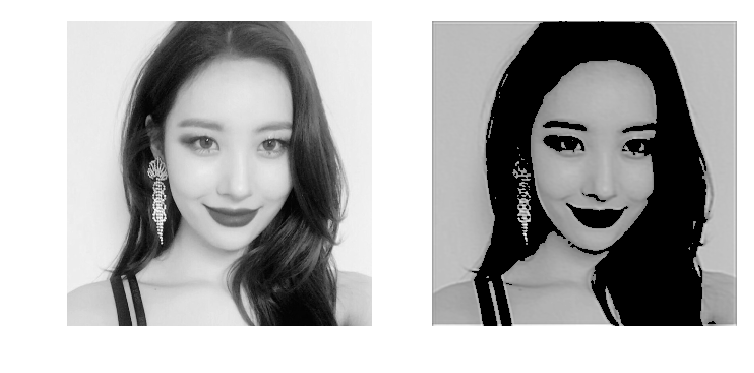

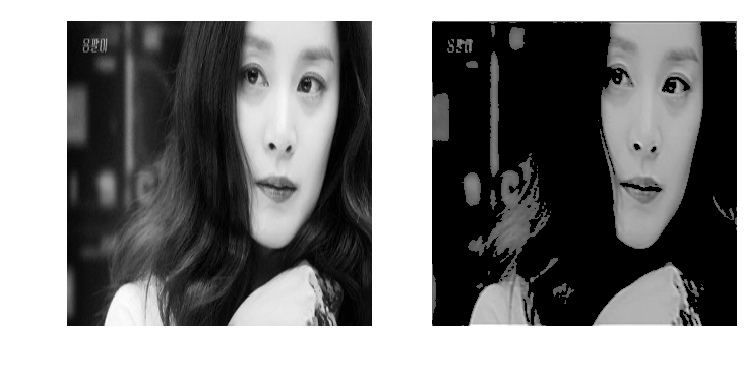

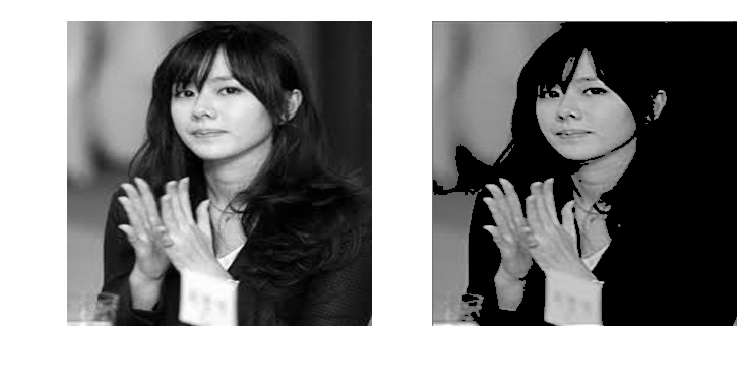

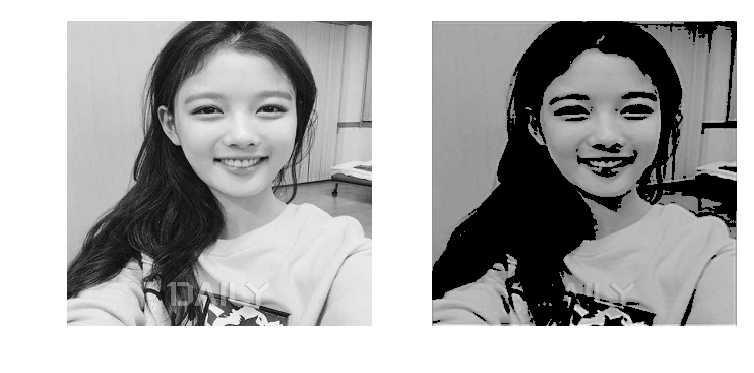

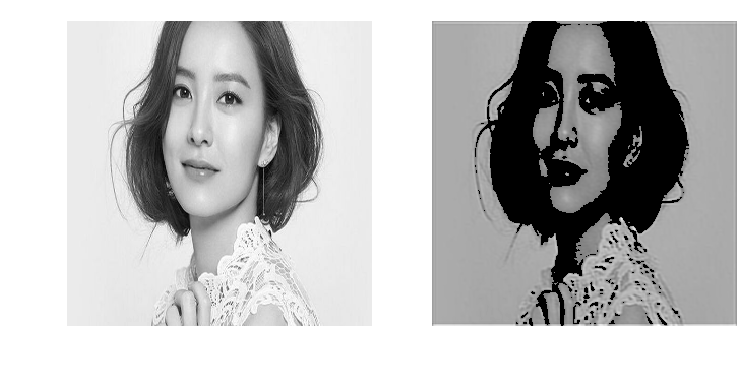

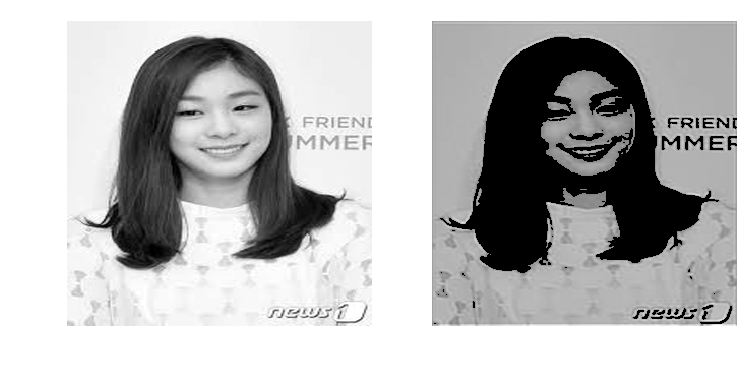

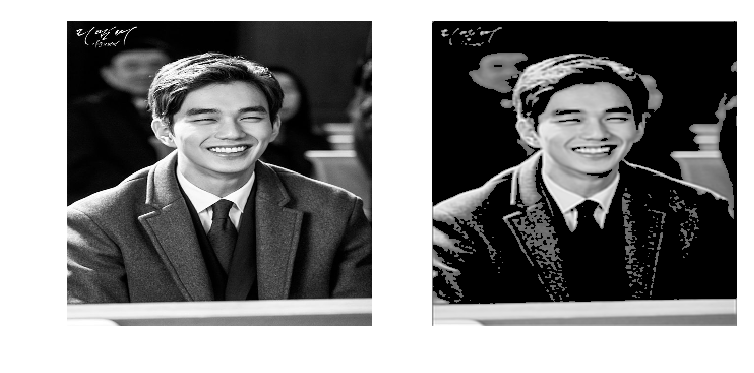

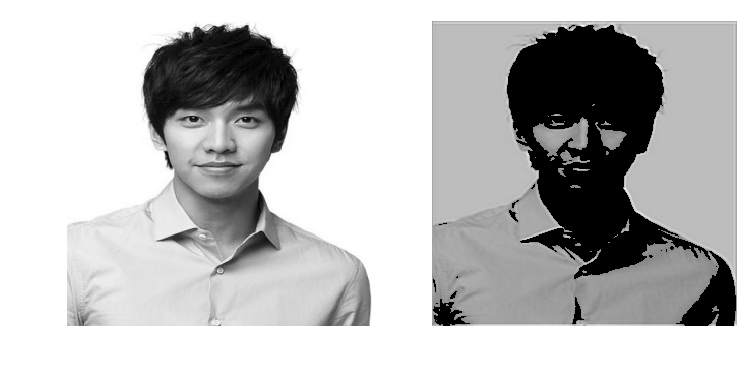

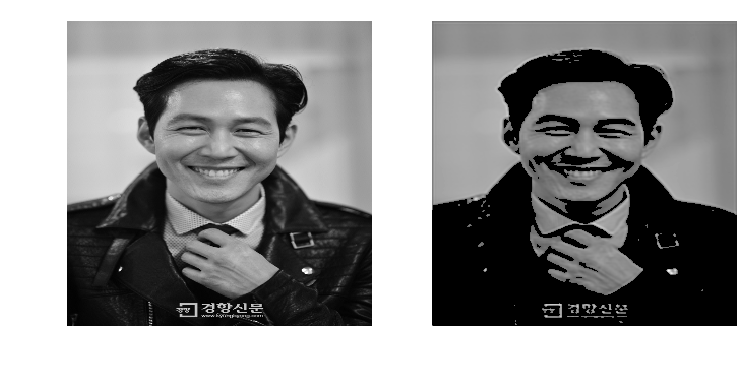

In [34]:
for real_img, test_real_img in zip(real_images, real_image_generated):
    
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(real_img.reshape(300, 300), cmap="gray")

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(test_real_img.reshape(300, 300), cmap="gray")
    plt.show()

In [ ]:
def test(self, args):
        """Test cyclegan"""
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        if args.which_direction == 'AtoB':
            sample_files = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testA'))
        elif args.which_direction == 'BtoA':
            sample_files = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testB'))
        else:
            raise Exception('--which_direction must be AtoB or BtoA')

        if self.load(args.checkpoint_dir):
            print(" [*] Load SUCCESS")
        else:
            print(" [!] Load failed...")

        # write html for visual comparison
        index_path = os.path.join(args.test_dir, '{0}_index.html'.format(args.which_direction))
        index = open(index_path, "w")
        index.write("<html><body><table><tr>")
        index.write("<th>name</th><th>input</th><th>output</th></tr>")

        out_var, in_var = (self.testB, self.test_A) if args.which_direction == 'AtoB' else (
            self.testA, self.test_B)
        

        for sample_file in sample_files:
            print('Processing image: ' + sample_file)
            sample_image = [load_test_data(sample_file, args.fine_size)]
            sample_image = np.array(sample_image).astype(np.float32)
            image_path = os.path.join(args.test_dir,
                                      '{}_{1}'.format(args.which_direction, os.path.basename(sample_file)))
            fake_img = self.sess.run(out_var, feed_dict={in_var: sample_image})
            save_images(fake_img, [1, 1], image_path)
            index.write("<td>%s</td>" % os.path.basename(image_path))
            index.write("<td><img src='%s'></td>" % (sample_file if os.path.isabs(sample_file) else (
                '..' + os.path.sep + sample_file)))
            index.write("<td><img src='%s'></td>" % (image_path if os.path.isabs(image_path) else (
                '..' + os.path.sep + image_path)))
            index.write("</tr>")
        index.close()


#### Save